# Transferência de Estilo Neural

### Notebook baseado no artigo: [markojerkic style transfer article](https://markojerkic.com/style-transfer-keras/)

 ## 1 - Importando dependências e algumas constantes

### * Imports:

In [2]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array

C:\Users\AdersonLucas\Documents\aderson\estudos\pos_graduacao\iesb\ia\iesb_ia\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\AdersonLucas\Documents\aderson\estudos\pos_graduacao\iesb\ia\iesb_ia\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\AdersonLucas\Documents\aderson\estudos\pos_graduacao\iesb\ia\iesb_ia\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

ImportError: cannot import name 'imsave'

### * Constantes:

In [2]:
CONTENT_IMG_PATH = './images/content1.jpg'
STYLE_IMG_PATH = './images/style1.jpg'
OUTPUT_PATH = './output/gen_img.jpg'

ITER = 10

# Pesos das funções perda (losses)
CONTENT_WEIGHT = 0.01
STYLE_WEIGHT = 1.0
TV_WEIGHT = 1.0

In [3]:
# Definindo o formato da imagem de saída
h, w = load_img(CONTENT_IMG_PATH).size
img_h = 400
img_w = int(h * img_h / w)

## 2 - Pré-processamento da imagem

#### Aqui estamos lendo a imagem a partir de seu arquivo (imagem do tipo Pillow) e convertendo para numpy array: 

In [4]:
def preprocess(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    
    # Adiciona um novo eixo (representando o batch)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [5]:
def deprocess_image(img):
    if K.image_data_format() == 'channels_first':
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_h, img_w, 3))
        
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    # converte de 'BGR'-->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

#### Aqui vamos inicializar as variáveis com a imagem de conteúdo, de estilo e a imagem gerada também:

In [3]:
# Create Keras variables of input images
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))

if K.image_data_format() == 'channels_first':
    gen_img = K.placeholder(shape=(1, 3, img_h, img_w))
else:
    gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# Create a single tensor containing all three images
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

# Create a vgg19 model by running the input tensor though the vgg19 convolutional
# neural network, excluding the fully connected layers
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

NameError: name 'preprocess' is not defined

#### Aqui cria-se um dicionário com as saídas das camadas, em que cada chave será o nome de uma camada e o valor da chave, os valores de saída da respectiva camada:

In [7]:
# Create an output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

## 3 - Cria-se as funções de perda ou *loss*

In [8]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Dot product of the flattened feature map and the transpose of the
    # flattened feature map
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = img_h * img_w
    # Euclidean distance of the gram matrices multiplied by the constant
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))


def content_loss(content, gen):
    assert K.ndim(content) == 3
    assert K.ndim(gen) == 3
    # Euclidean distance
    return K.sum(K.square(gen - content))


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, 1:, :img_w - 1])
        b = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, :img_h - 1, 1:])
    else:
        # Move the image pixel by pixel, and calculate the variance
        a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
        b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## 4 - Inicializa-se a função *loss* total

In [9]:
loss = 0.
# Para a loss de conteúdo, está sendo usad a segunda camada convolucional do quinto bloco convolucional da VGG19
layer_features = outputs_dict['block5_conv2']

content_img_features = layer_features[0, :, :, :]
gen_img_features = layer_features[2, :, :, :]

loss += CONTENT_WEIGHT * content_loss(content_img_features, gen_img_features)

# Camadas usadas para informação de estilo
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for name in feature_layer_names:
    layer_features = outputs_dict[name]
    
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    
    s1 = style_loss(style_features, gen_img_features)
    
    # Precisamos dividir a loss pelo número de camadas usadas para o estilo
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1

# Adicionamos a loss de variância total sobre a imagem gerada
loss += TV_WEIGHT * total_variation_loss(gen_img)

## 5 - Calcula Loss sobre as imagens usadas e cria uma Classe Evaluator para monitorar a loss e o gradiente na otimização

In [10]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)

def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_h, img_w))
    else:
        x = x.reshape((1, img_h, img_w, 3))
    # Atualiza a loss e o gradiente
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## 6 - Tempo de otimização

In [11]:
import matplotlib.pyplot as plt

/home/viniciusdoss/IESB- POS IA/TURMA 2018-1/pos_ia_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Step 0
    loss: 229698832.0
     Image saved. Time: 228.42371678352356


/home/viniciusdoss/IESB- POS IA/TURMA 2018-1/pos_ia_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


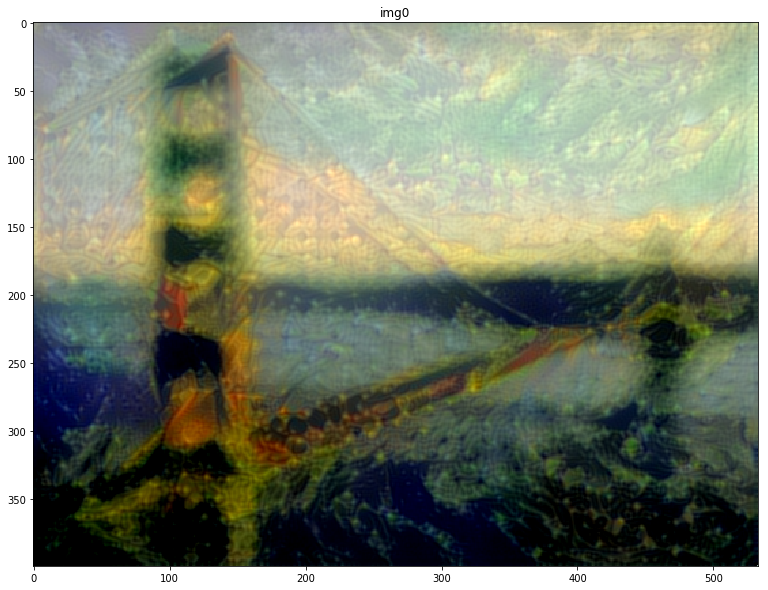

Step 1
    loss: 262692192.0
     Image saved. Time: 219.96312952041626


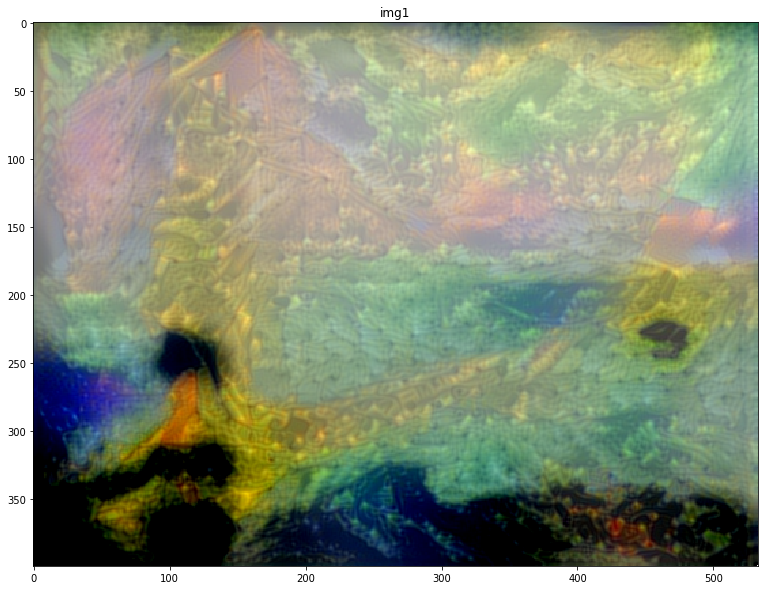

Step 2


KeyboardInterrupt: 

In [12]:
evaluator = Evaluator()

# Run L-BFGS optimizer
x = preprocess(CONTENT_IMG_PATH)

for i in range(ITER):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=300)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imsave('./output/img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.title('img{}'.format(i))
    plt.show()